In [ ]:
!pip install fashion-clip transformers torch torchvision

In [ ]:
import json
import pandas as pd
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image, ImageOps, ImageDraw
from tqdm.notebook import tqdm
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader, random_split
from google.colab import drive
from datasets import Dataset, features
from fashion_clip.fashion_clip import FashionCLIP
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

drive.mount('/content/drive')

In [ ]:
class CodiDataset(Dataset):
    def __init__(self, json_path, augment = False):
        with open(json_path, 'r') as f:
            data = json.load(f)

        self.codi_vectors = []
        self.augment = augment

        # 원본 벡터와 증강된 원본 벡터들을 데이터셋에 추가
        for v in data.values():
            if isinstance(v, list) and len(v) == 3:
                vector = torch.tensor(v, dtype=torch.float32).view(3, 512)
                self.codi_vectors.append(vector)  # 원본 벡터 추가

                # 여러 증강 버전 추가 (original vector만 증강)
                if self.augment:
                   augmented_ver = self.augment_vector(vector)
                   self.codi_vectors.extend(augmented_ver)

        print(f"CodiDataset - Loaded {len(self.codi_vectors)} codi vectors (including augmentations)")

    def __len__(self):
        return len(self.codi_vectors)

    def __getitem__(self, idx):
        original_vector = self.codi_vectors[idx]
        modified_vector = self.modify_vector(original_vector)
        return original_vector, modified_vector

    def augment_vector(self, vector):
        """original vector에 대해 각 증강을 개별적으로 적용하여 여러 증강 버전을 생성"""
        augmented_versions = []

        # 각 증강 기법을 개별적으로 적용
        augmented_versions.append(self.add_noise(vector.clone()))
        augmented_versions.append(self.scale_vector(vector.clone()))

        return augmented_versions

    def modify_vector(self, original_vector, change_count=2):
        modified_vector = original_vector.clone()
        available_indices = list(range(3))
        for _ in range(change_count):
            if not available_indices:
                break
            item_index = random.choice(available_indices)
            available_indices.remove(item_index)
            random_idx = random.randrange(len(self.codi_vectors))
            random_codi = self.codi_vectors[random_idx]
            modified_vector[item_index] = random_codi[item_index]
        return modified_vector

    def add_noise(self, vector, noise_level=0.01):
        noise = torch.randn_like(vector) * noise_level
        return vector + noise

    def scale_vector(self, vector, scale_range=(0.9, 1.1)):
        scale = random.uniform(*scale_range)
        return vector * scale

def collate_fn(batch):
    original_vectors, modified_vectors = zip(*batch)
    return torch.stack(original_vectors), torch.stack(modified_vectors)

In [ ]:
def plot_similarity_distribution(dataset, batch_size=8):
    original_similarities = []
    modified_similarities = []

    for i in range(0, len(dataset), batch_size):
        batch_indices = range(i, min(i + batch_size, len(dataset)))
        original_vectors_list = []
        modified_vectors_list = []

        for idx in batch_indices:
            original, modified = dataset[idx]
            original_vectors_list.append(original)
            modified_vectors_list.append(modified)

        original_vectors = torch.stack(original_vectors_list)
        modified_vectors = torch.stack(modified_vectors_list)

        # 각 아이템 쌍에 대한 유사도 계산
        for i in range(3):
            for j in range(i + 1, 3):
                # Original vector 유사도 계산
                original_sim = F.cosine_similarity(
                    original_vectors[:, i, :],
                    original_vectors[:, j, :],
                    dim=1
                )
                original_similarities.extend(original_sim.tolist())

                # Modified vector 유사도 계산
                modified_sim = F.cosine_similarity(
                    modified_vectors[:, i, :],
                    modified_vectors[:, j, :],
                    dim=1
                )
                modified_similarities.extend(modified_sim.tolist())

    plt.figure(figsize=(12, 6))
    plt.hist(original_similarities, bins=50, alpha=0.6, color='blue', label='Original Vectors')
    plt.hist(modified_similarities, bins=50, alpha=0.6, color='orange', label='Modified Vectors')
    plt.title('Similarity Distribution for Original and Modified Vectors')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

CodiDataset - Loaded 24288 codi vectors (including augmentations)
Train size: 19430, Test size: 4858


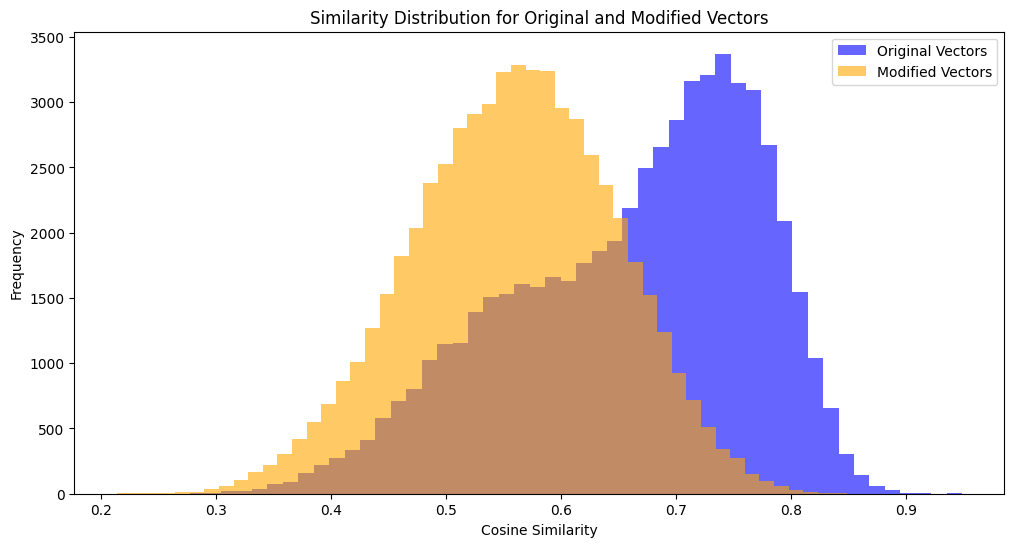

In [ ]:
json_path = '/content/drive/MyDrive/오뭐입/data/outfit_vectors.json'
dataset = CodiDataset(json_path)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

plot_similarity_distribution(train_dataset)

In [ ]:
class MatchingLoss(nn.Module):
    def __init__(self, threshold=0.75, temperature=0.07, dropout_rate=0.5):
        super().__init__()
        self.threshold = threshold
        self.temperature = nn.Parameter(torch.tensor(temperature))
        self.W = nn.Parameter(torch.randn(512, 512))
        self.dropout = nn.Dropout(dropout_rate)
        self.norm_layer = nn.LayerNorm(512)

    def forward(self, original_vectors, modified_vectors):
        # 텐서 모양 확인용 디버깅 메시지
        #print(f"MatchingLoss - Original Vectors Shape: {original_vectors.shape}, Modified Vectors Shape: {modified_vectors.shape}")

        original_embedded = F.normalize(torch.matmul(original_vectors, self.W), p=2, dim=-1)
        modified_embedded = F.normalize(torch.matmul(modified_vectors, self.W), p=2, dim=-1)

        original_similarities = []
        modified_similarities = []

        for i in range(3):
            for j in range(i + 1, 3):
                original_sim = F.cosine_similarity(
                    original_embedded[:, i, :],
                    original_embedded[:, j, :],
                    dim=-1  # 각 벡터가 512차원 상에서 유사도를 계산하도록 dim=-1로 설정
                ) / self.temperature
                modified_sim = F.cosine_similarity(
                    modified_embedded[:, i, :],
                    modified_embedded[:, j, :],
                    dim=-1
                ) / self.temperature

                original_similarities.append(original_sim)
                modified_similarities.append(modified_sim)

        # 모든 배치에 대해 유사도 계산 결과를 스택하여 평균을 구함
        original_similarities = torch.stack(original_similarities, dim=1).mean(dim=1)
        modified_similarities = torch.stack(modified_similarities, dim=1).mean(dim=1)

        target_loss = torch.relu(1 - original_similarities.mean())
        matching_loss = torch.relu(self.threshold - modified_similarities).mean()
        total_loss = target_loss + matching_loss

        return total_loss + 0.01*torch.norm(self.W, p=2)


In [ ]:
class What2Wear(nn.Module):
    def __init__(self, threshold=0.75, temperature=0.07, dropout_rate=0.5):
        super().__init__()
        self.loss_fn = MatchingLoss(threshold=threshold, temperature=temperature)

    def forward(self, original_vectors, modified_vectors):
        return self.loss_fn(original_vectors, modified_vectors)

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()

def train_model(json_path, save_path, num_epochs=30, batch_size=8):
    dataset = train_dataset
    validation_dataset = test_dataset

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = What2Wear(threshold=0.7, temperature=0.07, dropout_rate=0.5).to(device)

    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

    train_losses = []
    val_losses = []

    # 학습 루프
    for epoch in tqdm(range(num_epochs), leave=True):
        model.train()
        total_loss = 0
        batch_count = 0

        for i in range(0, len(dataset), batch_size):
            batch_indices = list(range(i, min(i + batch_size, len(dataset))))
            original_vectors_list = []
            modified_vectors_list = []

            for idx in batch_indices:
                original, modified = dataset[idx]
                original_vectors_list.append(original)
                modified_vectors_list.append(modified)

            original_vectors = torch.stack(original_vectors_list).to(device)
            modified_vectors = torch.stack(modified_vectors_list).to(device)

            optimizer.zero_grad()
            loss = model(original_vectors, modified_vectors)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

        avg_loss = total_loss / batch_count
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}")

        # 검증 손실 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, len(validation_dataset), batch_size):
                batch_indices = list(range(i, min(i + batch_size, len(validation_dataset))))
                original_vectors_list = []
                modified_vectors_list = []

                for idx in batch_indices:
                    original, modified = validation_dataset[idx]
                    original_vectors_list.append(original)
                    modified_vectors_list.append(modified)

                original_vectors = torch.stack(original_vectors_list).to(device)
                modified_vectors = torch.stack(modified_vectors_list).to(device)

                loss = model(original_vectors, modified_vectors)
                val_loss += loss.item()

        val_loss /= (len(validation_dataset) // batch_size)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

        scheduler.step()

        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"{save_path}_epoch{epoch+1}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'training_loss': avg_loss,
                'validation_loss': val_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")

    plot_losses(train_losses, val_losses)

    return model

In [ ]:
json_path = '/content/drive/MyDrive/오뭐입/data/outfit_vectors.json'
save_path = '/content/drive/MyDrive/오뭐입/What2Wear_model'

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Training Loss: 251.1496
Epoch [1/30], Validation Loss: 33.1120
Epoch [2/30], Training Loss: 11.0565
Epoch [2/30], Validation Loss: 5.0127
Epoch [3/30], Training Loss: 4.7017
Epoch [3/30], Validation Loss: 4.4998
Epoch [4/30], Training Loss: 4.3155
Epoch [4/30], Validation Loss: 4.1061
Epoch [5/30], Training Loss: 3.7771
Epoch [5/30], Validation Loss: 3.4020
Checkpoint saved: /content/drive/MyDrive/오뭐입/What2Wear_model_epoch5.pth
Epoch [6/30], Training Loss: 2.8932
Epoch [6/30], Validation Loss: 2.3505
Epoch [7/30], Training Loss: 2.0198
Epoch [7/30], Validation Loss: 1.6969
Epoch [8/30], Training Loss: 1.4030
Epoch [8/30], Validation Loss: 1.1665
Epoch [9/30], Training Loss: 0.9774
Epoch [9/30], Validation Loss: 0.8556
Epoch [10/30], Training Loss: 0.7263
Epoch [10/30], Validation Loss: 0.6478
Checkpoint saved: /content/drive/MyDrive/오뭐입/What2Wear_model_epoch10.pth
Epoch [11/30], Training Loss: 0.5747
Epoch [11/30], Validation Loss: 0.5160
Epoch [12/30], Training Loss: 0.4

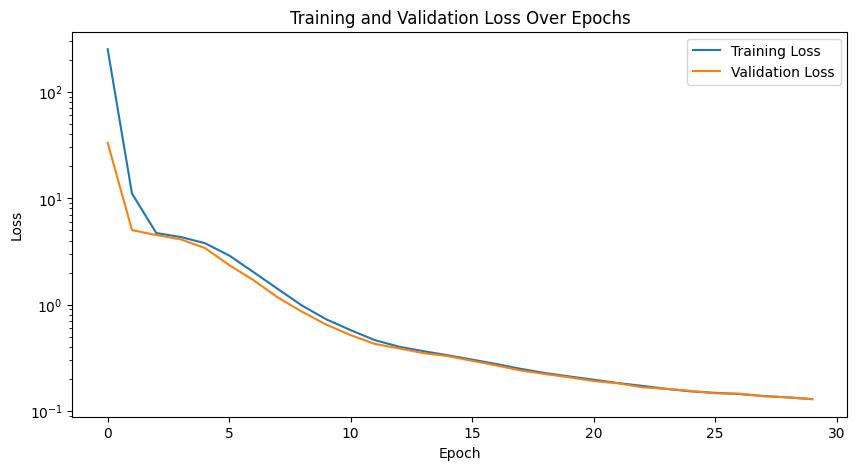

In [ ]:
model = train_model(json_path, save_path)

In [ ]:
# 학습이 완료된 후 모델 저장
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/오뭐입/What2Wear_model


In [ ]:
model = What2Wear()
model.load_state_dict(torch.load(save_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

<ipython-input-10-b0a4ce216dd6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


What2Wear(
  (loss_fn): MatchingLoss(
    (dropout): Dropout(p=0.5, inplace=False)
    (norm_layer): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
)

Computing similarity metrics...


  0%|          | 0/152 [00:00<?, ?it/s]


Plotting similarity distributions...


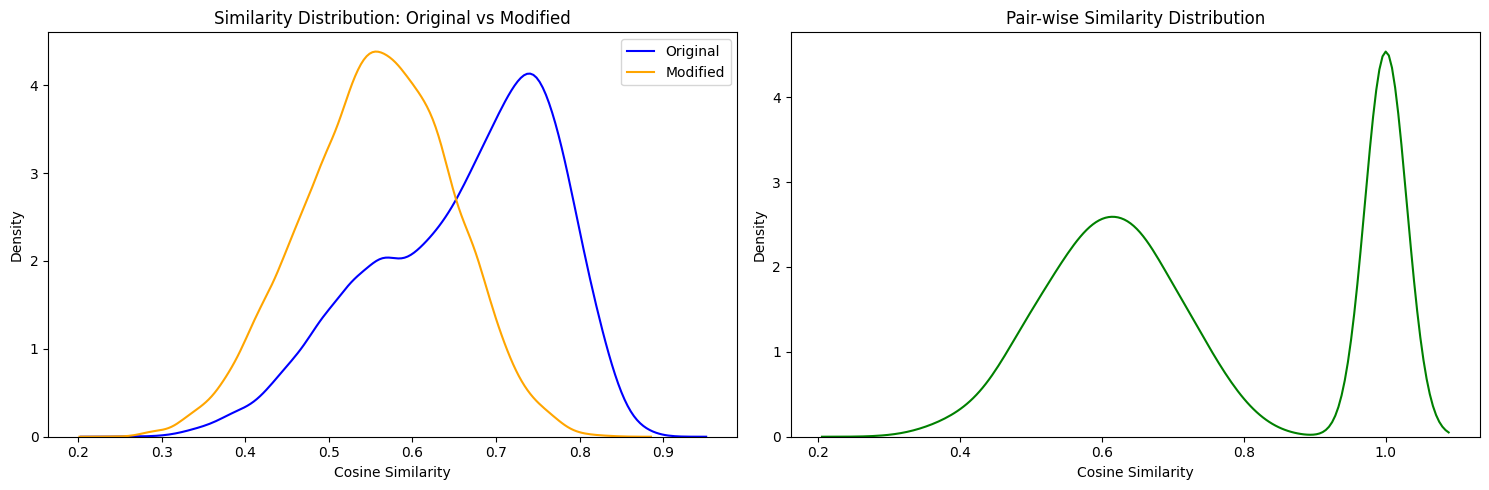


Computing threshold metrics...

Threshold Metrics:

Threshold 0.5:
Original Success Rate: 0.902
Modified Success Rate: 0.738
Pair Success Rate: 0.909

Threshold 0.7:
Original Success Rate: 0.443
Modified Success Rate: 0.047
Pair Success Rate: 0.454

Threshold 0.8:
Original Success Rate: 0.070
Modified Success Rate: 0.001
Pair Success Rate: 0.346

Threshold 0.85:
Original Success Rate: 0.006
Modified Success Rate: 0.000
Pair Success Rate: 0.336

Plotting threshold metrics...


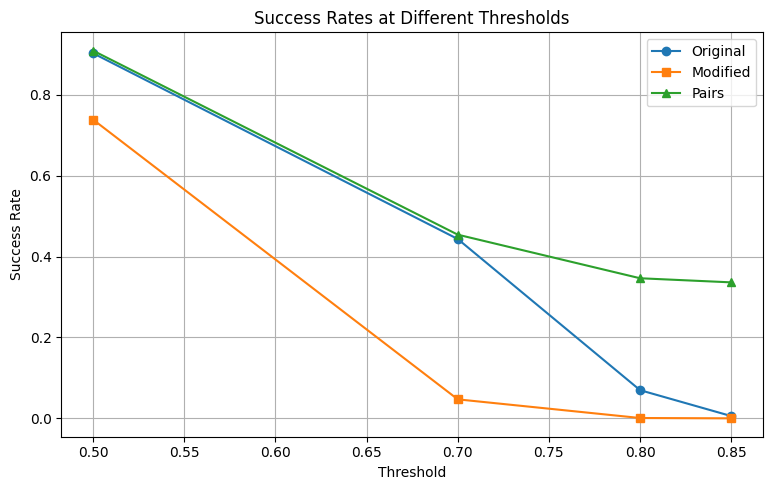

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class ModelEvaluator:
    def __init__(self, model, dataset, batch_size, device):
        self.model = model
        self.dataset = test_dataset
        self.batch_size = batch_size
        self.device = device
        self.model.eval()

    def compute_similarity_metrics(self):
        original_similarities = []
        modified_similarities = []
        pair_similarities = []

        with torch.no_grad():
            for i in tqdm(range(0, len(self.dataset), self.batch_size)):
                # 배치 인덱스 생성
                batch_indices = range(i, min(i + self.batch_size, len(self.dataset)))

                original_vectors = []
                modified_vectors = []
                for idx in batch_indices:
                    orig, mod = self.dataset[idx]
                    original_vectors.append(orig)
                    modified_vectors.append(mod)

                original_batch = torch.stack(original_vectors).to(self.device)
                modified_batch = torch.stack(modified_vectors).to(self.device)

                # 원본 벡터들 간의 유사도
                for i in range(3):
                    for j in range(i + 1, 3):
                        orig_sim = F.cosine_similarity(
                            original_batch[:, i],
                            original_batch[:, j],
                            dim=1
                        )
                        original_similarities.extend(orig_sim.cpu().numpy())

                        # 수정된 벡터들 간의 유사도
                        mod_sim = F.cosine_similarity(
                            modified_batch[:, i],
                            modified_batch[:, j],
                            dim=1
                        )
                        modified_similarities.extend(mod_sim.cpu().numpy())

                        # 원본-수정 벡터 쌍 간의 유사도
                        pair_sim = F.cosine_similarity(
                            original_batch[:, i],
                            modified_batch[:, i],
                            dim=1
                        )
                        pair_similarities.extend(pair_sim.cpu().numpy())

        return {
            'original': np.array(original_similarities),
            'modified': np.array(modified_similarities),
            'pairs': np.array(pair_similarities)
        }

    def plot_similarity_distributions(self, similarities):
        plt.figure(figsize=(15, 5))

        # 원본 vs 수정된 벡터 유사도 분포
        plt.subplot(1, 2, 1)
        sns.kdeplot(data=similarities['original'], label='Original', color='blue')
        sns.kdeplot(data=similarities['modified'], label='Modified', color='orange')
        plt.title('Similarity Distribution: Original vs Modified')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Density')
        plt.legend()

        # 원본-수정 벡터 쌍 유사도 분포
        plt.subplot(1, 2, 2)
        sns.kdeplot(data=similarities['pairs'], color='green')
        plt.title('Pair-wise Similarity Distribution')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Density')

        plt.tight_layout()
        plt.show()

    def compute_threshold_metrics(self, similarities, thresholds=[0.5, 0.7, 0.8, 0.85]):
        metrics = {}
        for threshold in thresholds:
            original_success = np.mean(similarities['original'] > threshold)
            modified_success = np.mean(similarities['modified'] > threshold)
            pair_success = np.mean(similarities['pairs'] > threshold)

            metrics[threshold] = {
                'original_success_rate': original_success,
                'modified_success_rate': modified_success,
                'pair_success_rate': pair_success
            }

        return metrics

    def plot_threshold_metrics(self, metrics):
        thresholds = list(metrics.keys())

        plt.figure(figsize=(15, 5))

        # Success Rates
        plt.subplot(1, 2, 1)
        plt.plot(thresholds, [m['original_success_rate'] for m in metrics.values()], 'o-', label='Original')
        plt.plot(thresholds, [m['modified_success_rate'] for m in metrics.values()], 's-', label='Modified')
        plt.plot(thresholds, [m['pair_success_rate'] for m in metrics.values()], '^-', label='Pairs')
        plt.title('Success Rates at Different Thresholds')
        plt.xlabel('Threshold')
        plt.ylabel('Success Rate')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def evaluate_model(model, test_dataset, batch_size=32, device='cuda'):
    evaluator = ModelEvaluator(model, test_dataset, batch_size, device)

    # 유사도 메트릭 계산
    print("Computing similarity metrics...")
    similarities = evaluator.compute_similarity_metrics()

    # 유사도 분포 시각화
    print("\nPlotting similarity distributions...")
    evaluator.plot_similarity_distributions(similarities)

    # 임계값별 메트릭 계산
    print("\nComputing threshold metrics...")
    threshold_metrics = evaluator.compute_threshold_metrics(similarities)

    # 결과 출력
    print("\nThreshold Metrics:")
    for threshold, metrics in threshold_metrics.items():
        print(f"\nThreshold {threshold}:")
        print(f"Original Success Rate: {metrics['original_success_rate']:.3f}")
        print(f"Modified Success Rate: {metrics['modified_success_rate']:.3f}")
        print(f"Pair Success Rate: {metrics['pair_success_rate']:.3f}")

    # 임계값별 메트릭 시각화
    print("\nPlotting threshold metrics...")
    evaluator.plot_threshold_metrics(threshold_metrics)

    return similarities, threshold_metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
similarities, metrics = evaluate_model(model, test_dataset, batch_size=32, device=device)

In [ ]:
fclip = FashionCLIP('fashion-clip')

In [ ]:
def generate_vector(input_data, data_type='image'):
    """
    입력 데이터를 (512)-차원 벡터로 변환하는 함수.
    input_data: 이미지 경로나 텍스트 캡션
    data_type: 'image' 또는 'text'
    """
    if data_type == 'image':
        image = Image.open(input_data).convert('RGB')

        dataset = Dataset.from_dict({"image": [{"path": input_data}]})
        dataset = dataset.cast_column("image", features.Image())

        # fclip.encode_images 사용하여 벡터 생성
        vector = fclip.encode_images(dataset["image"], batch_size=32)
    elif data_type == 'text':
        vector = fclip.encode_text([input_data], batch_size=32)

    return torch.tensor(vector.squeeze())


def generate_vectors_from_list(image_list):
    vectors = []
    paths = []
    for image_path in image_list:
        vector = generate_vector(image_path, data_type='image')
        vectors.append(vector)
        paths.append(image_path)
    return torch.stack(vectors), paths

In [ ]:
# 입력 데이터
new_single_item_path = '/content/drive/MyDrive/오뭐입/sample/W2W/스크린샷 2024-11-01 오후 10.38.19.png'
new_item_category = 'top'  # 'top', 'bottom', 또는 'shoe' 중 하나로 설정

# 해당 카테고리가 아닌 다른 아이템 이미지 목록
new_top_images = ['top_image_1.jpg', 'top_image_2.jpg', ...] # 상의 이미지 목록
new_bottom_images = ['/content/drive/MyDrive/오뭐입/sample/W2W/bottom/스크린샷 2024-11-01 오후 9.41.04.png',
                     '/content/drive/MyDrive/오뭐입/sample/W2W/bottom/스크린샷 2024-11-01 오후 9.41.17.png',
                     '/content/drive/MyDrive/오뭐입/sample/W2W/bottom/스크린샷 2024-11-01 오후 9.42.36.png',
                     '/content/drive/MyDrive/오뭐입/sample/W2W/bottom/스크린샷 2024-11-01 오후 9.43.16.png',
                     '/content/drive/MyDrive/오뭐입/sample/W2W/bottom/스크린샷 2024-11-01 오후 9.44.24.png']  # 하의 이미지 목록
new_shoes_images = ['/content/drive/MyDrive/오뭐입/sample/W2W/shoes/스크린샷 2024-11-01 오후 9.46.11.png',
                    '/content/drive/MyDrive/오뭐입/sample/W2W/shoes/스크린샷 2024-11-01 오후 9.46.33.png',
                    '/content/drive/MyDrive/오뭐입/sample/W2W/shoes/스크린샷 2024-11-01 오후 9.47.40.png',
                    '/content/drive/MyDrive/오뭐입/sample/W2W/shoes/스크린샷 2024-11-01 오후 9.48.19.png',
                    '/content/drive/MyDrive/오뭐입/sample/W2W/shoes/스크린샷 2024-11-01 오후 9.49.21.png']  # 신발 이미지 목록

# 단일 아이템 벡터 생성
new_single_item_vector = generate_vector(new_single_item_path, data_type='image')
new_bottom_list, bottom_path = generate_vectors_from_list(new_bottom_images)
new_shoe_list, shoe_path = generate_vectors_from_list(new_shoes_images)
new_bottom_vector = new_bottom_list[0]
new_shoe_vector = new_shoe_list[0]

In [ ]:
new_single_item_vector

array([ 4.81742993e-02, -3.22250462e+00, -3.53221118e-01, -3.79584879e-01,
       -1.29513517e-01, -3.25896651e-01,  4.99740392e-01, -4.54545841e-02,
        2.56622314e-01,  3.44515622e-01, -4.51339573e-01, -4.25055623e-03,
       -3.10719050e-02, -3.03479761e-01, -1.80582255e-01,  2.61583686e-01,
       -1.65325487e+00, -5.72260976e-01,  5.81180811e-01,  1.83941364e-01,
       -6.65680766e-01, -2.51119673e-01,  1.19290203e-02,  5.91963232e-01,
        1.66044533e-01, -9.69344735e-01,  2.84574449e-01,  1.61473781e-01,
       -2.20196038e-01,  2.49026284e-01,  6.51694685e-02,  6.58422709e-01,
       -3.72837394e-01, -2.66691446e-02, -2.99646586e-01,  1.66929334e-01,
       -3.29657197e-01,  2.36390650e-01,  1.63567215e-01, -1.39926091e-01,
       -3.15389276e-01, -2.96125822e-02,  3.34646583e-01,  5.11507988e-01,
        5.42243198e-02,  1.83088407e-01,  4.40127462e-01,  2.35159010e-01,
       -4.87400353e-01,  4.56052721e-01,  1.15336597e-01, -7.56368756e-01,
        1.16518021e-01,  

In [ ]:
print(new_bottom_vector[0])
print(len(new_bottom_list))
print(new_bottom_list[0])
print(bottom_path[0])
print(len(new_bottom_vector))

tensor(0.5195)
5
tensor([ 5.1948e-01, -3.5459e-01,  2.0678e-01, -1.8679e-01,  3.1184e-01,
        -6.3091e-02, -6.5356e-02,  3.9363e-01, -2.7517e-01,  6.3648e-01,
         2.3692e-02, -1.4896e-01,  1.6211e-01, -2.7408e-03, -3.4422e-01,
         3.7319e-01, -2.1996e-02,  3.3451e-01,  6.4168e-01, -5.3942e-01,
        -1.0494e-01, -2.2161e-01, -5.9685e-01,  1.1276e-01,  1.1308e-01,
        -2.9316e-01,  5.2055e-02,  4.2699e-01,  1.4331e-01,  3.5170e-01,
        -5.3666e-01,  7.7309e-01,  4.0992e-01, -2.0762e-01,  2.1350e-01,
         2.6761e-01,  4.2104e-03, -4.9626e-01, -1.3275e-01,  1.0853e-01,
        -2.4792e-01, -3.8932e-01,  7.8871e-02, -1.2359e-01, -3.0177e-01,
        -8.7292e-01, -2.1553e-01, -1.0569e-01, -3.4173e-01,  8.3549e-02,
        -4.6710e-01, -2.9659e-01, -2.3294e-01, -5.4620e-01,  4.4104e-01,
        -5.8118e-02, -1.3062e-01,  1.0461e-01,  2.4527e-01,  3.6058e-01,
        -1.1121e+00, -4.6685e-01,  4.9572e-01,  2.8602e-01, -1.1566e-01,
         6.5472e-01, -5.9895e-01, 

In [ ]:
class What2Wear_Recommendation:
    def __init__(self, model):
        """
        model: 학습된 What2Wear 인스턴스
        """
        self.model = model

    def find_best_match(self, item_vector, category, bottoms=None, shoes=None, tops=None, bottom_paths=None, shoe_paths=None, top_paths=None):
        """
        item_vector: 단일 아이템 벡터 (512,)
        category: item_vector의 카테고리 ('top', 'bottom', 'shoe' 중 하나)
        bottoms: 하의 아이템 벡터들 (n, 512)
        shoes: 신발 아이템 벡터들 (n, 512)
        tops: 상의 아이템 벡터들 (n, 512)
        bottom_paths, shoe_paths, top_paths: 각 아이템의 이미지 경로 리스트
        """

        # 단일 아이템의 카테고리에 따라 다른 조합으로 탐색
        if category == 'top' and bottoms is not None and shoes is not None:
            return self._find_best_bottom_shoe(item_vector, bottoms, shoes, bottom_paths, shoe_paths)
        elif category == 'bottom' and tops is not None and shoes is not None:
            return self._find_best_top_shoe(item_vector, tops, shoes, top_paths, shoe_paths)
        elif category == 'shoe' and tops is not None and bottoms is not None:
            return self._find_best_top_bottom(item_vector, tops, bottoms, top_paths, bottom_paths)
        else:
            raise ValueError("Invalid input: Please provide appropriate vectors for the given category.")

    def _find_best_bottom_shoe(self, top_vector, bottoms, shoes, bottom_paths, shoe_paths):
        """단일 아이템이 상의일 때, 가장 어울리는 하의와 신발 조합을 찾음"""
        best_loss = float('inf')
        best_bottom_index = None
        best_shoe_index = None

        top_vector = top_vector.unsqueeze(0)  # (1, 512)

        for i, bottom in enumerate(bottoms):
            bottom = bottom.unsqueeze(0)
            for j, shoe in enumerate(shoes):
                shoe = shoe.unsqueeze(0)

                outfit_vector = torch.stack([top_vector, bottom, shoe], dim=1).squeeze(0)  # (3, 512)
                loss = self.model(outfit_vector.unsqueeze(0), outfit_vector.unsqueeze(0))  # (1, 3, 512)
                print(f'top + {i}th bottom + {j}th shoes loss = {loss}')

                if loss < best_loss:
                    best_loss = loss
                    best_bottom_index = i
                    best_shoe_index = j

        # 최종 인덱스로 이미지 경로 반환
        best_bottom_path = bottom_path[best_bottom_index] if best_bottom_index is not None else None
        best_shoe_path = shoe_path[best_shoe_index] if best_shoe_index is not None else None

        return best_bottom_path, best_shoe_path, best_bottom_index, best_shoe_index

<ipython-input-73-1b0795f4b23d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))  # 모델 체크포인트 경로로 변경


top + 0th bottom + 0th shoes loss = 11.82717514038086
top + 0th bottom + 1th shoes loss = 5.969583988189697
top + 0th bottom + 2th shoes loss = 7.452408790588379
top + 0th bottom + 3th shoes loss = 10.559337615966797
top + 0th bottom + 4th shoes loss = 10.565935134887695
top + 1th bottom + 0th shoes loss = 9.706009864807129
top + 1th bottom + 1th shoes loss = 4.279524326324463
top + 1th bottom + 2th shoes loss = 4.252191543579102
top + 1th bottom + 3th shoes loss = 8.214659690856934
top + 1th bottom + 4th shoes loss = 7.266567707061768
top + 2th bottom + 0th shoes loss = 10.493409156799316
top + 2th bottom + 1th shoes loss = 7.8432135581970215
top + 2th bottom + 2th shoes loss = 7.166965007781982
top + 2th bottom + 3th shoes loss = 8.482367515563965
top + 2th bottom + 4th shoes loss = 9.243128776550293
top + 3th bottom + 0th shoes loss = 13.204192161560059
top + 3th bottom + 1th shoes loss = 10.134870529174805
top + 3th bottom + 2th shoes loss = 10.521865844726562
top + 3th bottom + 3t

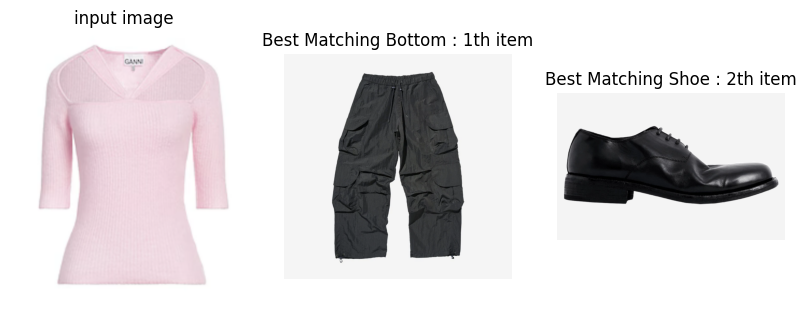

In [ ]:
model = What2Wear()
model.load_state_dict(torch.load(save_path))
model.eval()

recommendation_system = What2Wear_Recommendation(model)

# 단일 아이템이 상의일 때, 가장 어울리는 하의와 신발 이미지 경로 찾기
best_bottom_path, best_shoe_path, best_bottom_index, best_shoe_index = recommendation_system.find_best_match(
    new_single_item_vector, category='top', bottoms=new_bottom_list, shoes=new_shoe_list,
    bottom_paths=new_bottom_list, shoe_paths=new_shoe_list
)

print(best_bottom_path)

# 결과 이미지 출력
def display_images(bottom_path, shoe_path):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    input_image = Image.open(new_single_item_path)
    axes[0].imshow(input_image)
    axes[0].axis('off')
    axes[0].set_title("input image")

    bottom_image = Image.open(bottom_path)
    axes[1].imshow(bottom_image)
    axes[1].axis('off')
    axes[1].set_title(f"Best Matching Bottom : {best_bottom_index}th item")

    shoe_image = Image.open(shoe_path)
    axes[2].imshow(shoe_image)
    axes[2].axis('off')
    axes[2].set_title(f"Best Matching Shoe : {best_shoe_index}th item")

    plt.show()

display_images(best_bottom_path, best_shoe_path)

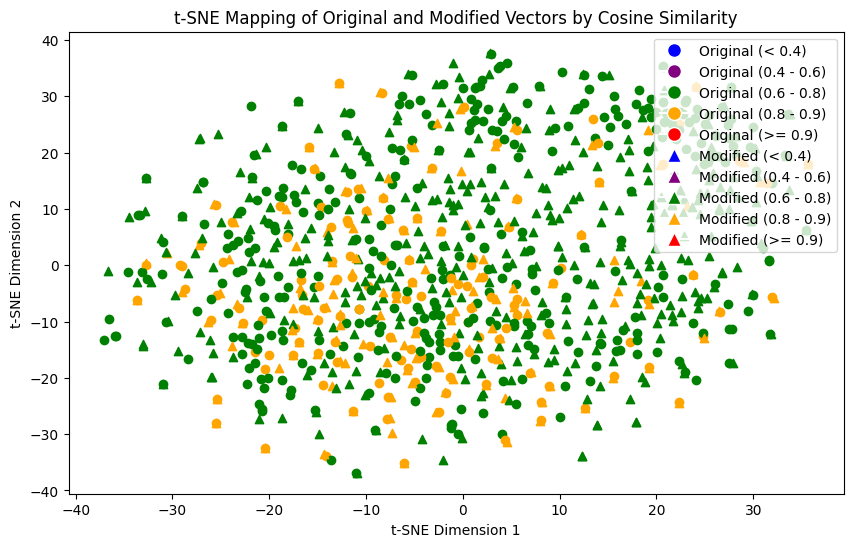

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np

def plot_tsne_without_pca(dataset, n_samples=500, thresholds=[0.4, 0.6, 0.8, 0.9], random_seed=42):
    original_vectors = []
    modified_vectors = []
    similarities = []

    # 랜덤으로 데이터 샘플링
    indices = torch.randperm(len(dataset))[:n_samples]
    for idx in indices:
        original, modified = dataset[idx]

        # flatten()을 사용하여 3 x 512 벡터를 1536 차원으로 펼침
        original_vector = original.flatten()
        modified_vector = modified.flatten()

        original_vectors.append(original_vector)
        modified_vectors.append(modified_vector)

        # cosine similarity 계산
        similarity = F.cosine_similarity(original_vector.unsqueeze(0), modified_vector.unsqueeze(0)).item()
        similarities.append(similarity)

    # 텐서로 변환
    original_vectors = torch.stack(original_vectors)
    modified_vectors = torch.stack(modified_vectors)

    # t-SNE로 차원 축소 (1536 -> 2)
    tsne = TSNE(n_components=2, random_state=random_seed)
    vectors_combined = torch.cat([original_vectors, modified_vectors], dim=0).cpu().numpy()
    tsne_results = tsne.fit_transform(vectors_combined)

    tsne_original = tsne_results[:n_samples]
    tsne_modified = tsne_results[n_samples:]

    colors_original = []
    colors_modified = []

    for sim in similarities:
        if sim >= thresholds[3]:
            color = 'red'
        elif sim >= thresholds[2]:
            color = 'orange'
        elif sim >= thresholds[1]:
            color = 'green'
        elif sim >= thresholds[0]:
            color = 'blue'
        else:
            color = 'purple'
        colors_original.append(color)
        colors_modified.append(color)

    plt.figure(figsize=(10, 6))

    # 원본 벡터 (동그라미)
    for i, (x, y) in enumerate(tsne_original):
        plt.scatter(x, y, color=colors_original[i], marker='o', label='Original' if i == 0 else "")

    # 수정된 벡터 (세모)
    for i, (x, y) in enumerate(tsne_modified):
        plt.scatter(x, y, color=colors_modified[i], marker='^', label='Modified' if i == 0 else "")

    # 그래프 설정
    plt.title("t-SNE Mapping of Original and Modified Vectors by Cosine Similarity")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=f'Original (< {thresholds[0]})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label=f'Original ({thresholds[0]} - {thresholds[1]})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label=f'Original ({thresholds[1]} - {thresholds[2]})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label=f'Original ({thresholds[2]} - {thresholds[3]})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f'Original (>= {thresholds[3]})'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label=f'Modified (< {thresholds[0]})'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='purple', markersize=10, label=f'Modified ({thresholds[0]} - {thresholds[1]})'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label=f'Modified ({thresholds[1]} - {thresholds[2]})'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='orange', markersize=10, label=f'Modified ({thresholds[2]} - {thresholds[3]})'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label=f'Modified (>= {thresholds[3]})')
    ], loc='upper right')

    plt.show()

# 예제 사용
plot_tsne_without_pca(test_dataset, n_samples=500)